---
# Experimental Observations
---
In this notebook, we aim to run illustrative experiments that shows interesting behaviour in singular models predicted by SLT or might require further investigation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import pyro
pyro.enable_validation(True)
pyro.set_rng_seed(1)

from utils import *
from models import *

%reload_ext autoreload
%autoreload 1
%aimport utils
%aimport models


def _plot_regression_model(
    sample_sizes, 
    num_repeat, 
    regression_fn, 
    w_true, 
    sigma=0.5, 
    axis_min=-1.0, 
    axis_max=1.0
):
    w1_axis = np.linspace(axis_min, axis_max, num=100)
    w2_axis = np.linspace(axis_min, axis_max, num=100)
    W1, W2 = np.meshgrid(w1_axis, w2_axis)
    fig, axes = plt.subplots(
        len(sample_sizes), num_repeat, figsize=(num_repeat * 3, len(sample_sizes) * 3), 
        sharex=True, sharey=True
    )
    axes = np.ravel(axes)
    c = 0
    for n in sample_sizes:
        for _ in range(num_repeat):
            ax = axes[c]
            ax.scatter([w_true[0]], [w_true[1]], s=80, color="blue", marker="X")
            ax.vlines([0], ymin=axis_min, ymax=axis_max, linestyles="dashed", color="red", alpha=0.5)
            ax.hlines([0], xmin=axis_min, xmax=axis_max, linestyles="dashed", color="red", alpha=0.5)

            X = (np.random.rand(n) - 1/2) * 2
            noise = np.random.randn(n) * sigma
            y = regression_fn(X, w_true[0], w_true[1]) + noise

            nll_0 = nll(X, y, w_true[0], w_true[1], regression_fn, sigma)
            K = np.array([[nll(X, y, w1, w2, regression_fn, sigma) - nll_0 for w2 in w2_axis] for w1 in w1_axis])
            ax.contour(W1, W2, np.exp(-n * K), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
            ax.set_title(f"n={n}", fontsize=10)
            c += 1
    return fig, ax

---
# Likelihood fluctuation of a regular model
---
In regular model (everywhere non-singular Fisher information, singleton true parameter set), the posterior converges to a Gaussian distribution. However, the posterior distribution depends on the randomly sampled dataset $D_n = \{(X_i, Y_i)\}$, so it is itself a random variable. But when $n$ is large enough for the posterior to be well approximated by a Gaussian $N(\mu, \sigma^2 / n)$, we can be sure that the posterior is concentrated near $\mu$ which asymptotically approach the (unique) true parameter. 

In the example below, we investigate linear regression with Gaussian noise. 

$$y = w_1 x + w_2 + \epsilon, \quad \epsilon \sim N(0, \sigma^2)$$

which translates to the following regular model: 

$$p(y | x, w_1, w_2) = \frac{1}{\sqrt{2 \pi}} \exp\left(\frac{(y - w_1 x - w_2)^2}{2 \sigma^2}\right)$$. 

The contour plot below, shows a plot of $exp(-n * (L_n(w_1, w_2) - L_n(w^*_1, w^*_2))$ where 

$$ L_n(w_1, w_2) = -\frac{1}{n} \sum_{i = 1}^n \log p(Y_i |X_i, w_1, w_2) = -\frac{1}{n} \sum_{i = 1}^n (Y_i - w_1 X_i - w_2)^2 + const $$

is the negative log-likelihood of the model. Given a uniform prior distribution, the plotted quantity is proportional to the (normalised) posterior distribution. 




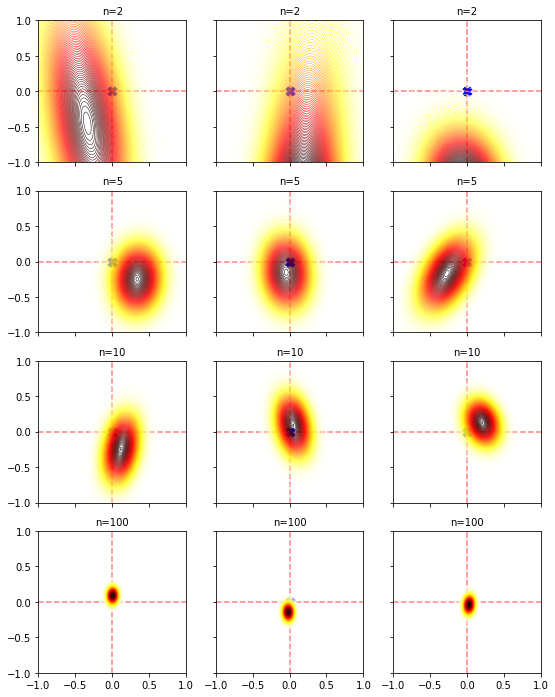

In [2]:
def linear_regression_fn(x, w1, w2):
    return w1 * x + w2


def nll(X, y, w1, w2, regression_fn, sigma):
    return (
        np.mean((y - regression_fn(X, w1, w2))**2) * (1 / (2 * sigma**2)) 
        + 1/2 * np.log(2 * np.pi)
    )


fig, ax = _plot_regression_model([2, 5, 10, 100], 3, linear_regression_fn, (0, 0), sigma=0.5)



---
# When truth is singular for a model
---
We now consider the scenario when the true distribution is singular for a model, meaning 
  1. The Fisher information for the model is singular somewhere. 
  2. The true parameter is in the locus where the Fisher information is singular. 

In this case, the posterior cannot be approximated by Gaussian distribution


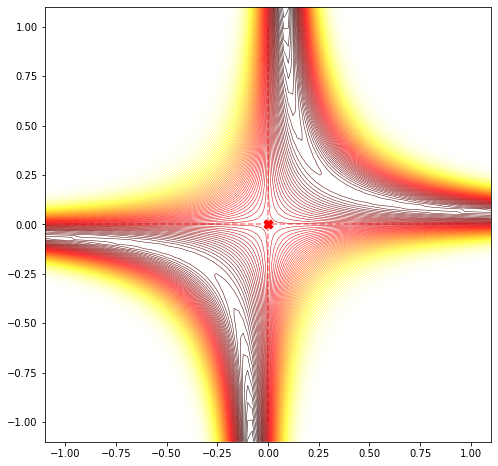

In [3]:
w_true = (0.0, 0.0)
model_true = OneHiddenLayerTanhNetwork(input_dim=1, output_dim=1, H=1, init_param=w_true)

n = 100
sigma = 0.5
X_train, y_train = make_dataset(model_true, n, sigma)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter([w_true[0]], [w_true[1]], s=80, color="red", marker="X")

ax.vlines([0], ymin=-1, ymax=1, linestyles="dashed", color="red", alpha=0.5)
ax.hlines([0], xmin=-1, xmax=1, linestyles="dashed", color="red", alpha=0.5)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
w1_axis = np.linspace(xmin, xmax, num=100)
w2_axis = np.linspace(ymin, ymax, num=100)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    W1 = torch.tensor(W1)
    W2 = torch.tensor(W2)
    Z = torch.stack(
        [((W1 * torch.tanh(W2 * xval)) - yval)**2 * (1 / (2 * sigma**2))
         for xval, yval in zip(X_train, y_train)]
    ).mean(axis=0)

ax.contour(W1, W2, np.exp(-n * Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")


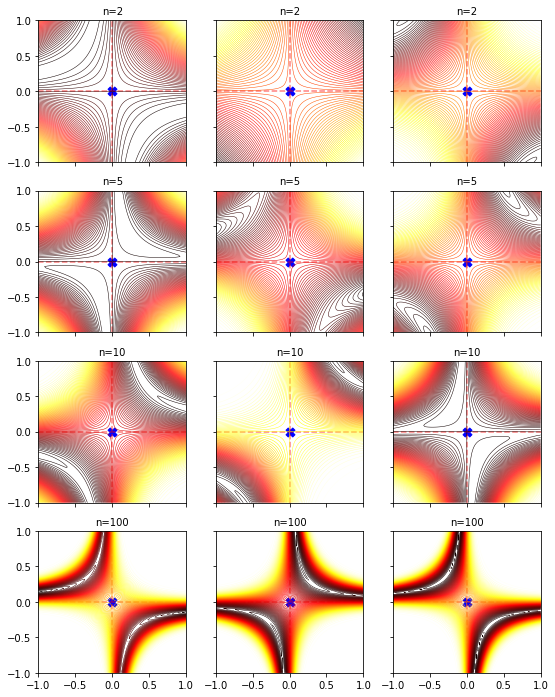

In [4]:
def tanh_regression_fn(x, w1, w2):
    return w1 * np.tanh(w2 * x)

fig, ax = _plot_regression_model([2, 5, 10, 100], 3, tanh_regression_fn, (0, 0), sigma=0.5)



---
# When true is regular for a singular model
---

$$p(y | x, w) = \frac{1}{\sqrt{2 \pi}} \exp\left(\frac{(y - f(x, w))^2}{2 \sigma^2}\right)$$. 


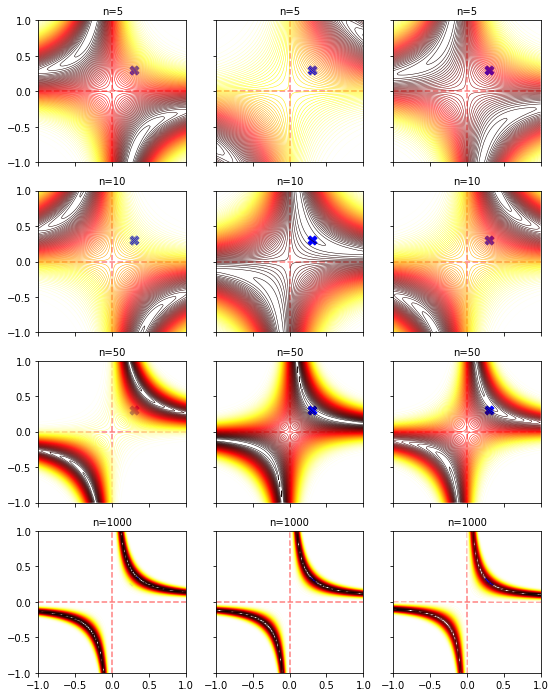

In [6]:
fig, ax = _plot_regression_model([5, 10, 50, 1000], 3, tanh_regression_fn, (0.3, 0.3), sigma=0.5)

---
# "Delicate case"
---

---
# Unrealisable regular model
---
# Unrealisable truth that is regular for a singular model
---
# Unrealisable truth that is singular for a singular model
---
# Non-renormalisable case
---

---
# Experiments to illustrate Green book Chapter 9.5
---